# Previsão de renda

## Índice <a name="topo"></a>

1. [Etapa 1 Crisp - DM: Entendimento do negócio](#1)
2. [Etapa 2 Crisp - DM: Entendimento dos dados](#2)
3. [Etapa 4 Crisp - DM: Preparação dos dados](#3)
4. [Etapa 4 Crisp - DM: Modelagem](#4)
5. [Etapa 5 Crisp - DM: Avaliação dos resultados](#5)
6. [Etapa 6 Crisp - DM: Implantação](#6)

### 4 elementos importantes
- Esse notebook
- Streamlit com as análises
- Seu Github com o projeto
- Vídeo no readme do github mostrando o streamlit

## Etapa 1 CRISP - DM: Entendimento do negócio<a name="1"></a>
<div style="text-align: right" 
     
[Voltar ao índice](#topo)

O objetivo desta análise é prever a variação de renda dos clientes de uma instituição financeira. Os dados utilizados na análise e previsão foram coletados e distribuidos em variáveis com características diversas que auxiliam na previsão ou explicação da renda de um cliente.

## Etapa 2 Crisp-DM: Entendimento dos dados <a name="2"></a>

<div style="text-align: right" 
     
[Voltar ao índice](#topo)

Foram fornecidas diversas variáveis que ao final foram reduzidas para 14 que se mostraram mais condizentes com os propósitos da análise
 

 <h1><center>Dicionário de dados</center></h1> 

| Variável                | Descrição                                           | Tipo         |
| ----------------------- |:---------------------------------------------------:| ------------:|
| data_ref                |  Data de referência da coleta do dado               | texto|
| id_cliente              |  Número de identificação do cliente                 | inteiro|
| sexo                    |  M = 'Masculino'; F = 'Feminino'                    | inteiro|
| posse_de_veiculo        |  True = 'possui'; False = 'não possui'              | booleana|
| posse_de_imovel         |  True = 'possui'; False = 'não possui'              | booleana|
| qtd_filhos              |  Quantidade de filhos do cliente                    | inteiro|
| tipo_renda              |  Tipo de renda (ex: assaliariado, autônomo etc)     | texto|
| educacao                |  Nível educacional (ex: secundário, superior etc)   | texto|
| estado_civil            |  Estado civil (ex: solteiro, casado etc)            | texto|
| tipo_residencia         |  Tipo de residência (ex: casa/apartamento, com os pais etc)| texto|
| idade                   |  Idade em anos                                      | inteiro|
| tempo_emprego           |  Tempo de emprego em anos                           | float|
| qt_pessoas_residencia   |  Quantidade de pessoas na residência                | float|
| renda                   |  Valor da renda mensal                              | float|

#### Carregando os pacotes
É considerado uma boa prática carregar os pacotes que serão utilizados como a primeira coisa do programa.

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

# from pandas_profiling import ProfileReport --- parece não existir mais
from ydata_profiling import ProfileReport # usei o pip install ydata_profiling

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn import tree

import streamlit as st

%matplotlib inline

C:\ProgramData\anaconda3\Lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
C:\Users\khrik\AppData\Roaming\Python\Python311\site-packages\visions\backends\shared\nan_handling.py:50: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @nb.jit


In [2]:
# rodando o algorítimo que cria o método stepwise_selection
# este método permite que a seleção de variáveis usando ambas estratégias forward e backward

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.05, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded, dtype=np.dtype('float64'))
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.index[new_pval.argmin()]
            included.append(best_feature)
            changed=True
            if verbose:
                 print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        print("#############")
        print(included)
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

#### Carregando os dados 
O comando pd.read_csv é um comando da biblioteca pandas (pd.) e carrega os dados do arquivo csv indicado para um objeto *dataframe* do pandas.

In [3]:
renda = pd.read_csv('./input/previsao_de_renda.csv')
renda.head(5)

,Unnamed: 0,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,0,2015-01-01,15056,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34
1,1,2015-01-01,9968,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15
2,2,2015-01-01,4312,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,2253.89
3,3,2015-01-01,10639,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,4.846575,3.0,6600.77
4,4,2015-01-01,7064,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1.0,6475.97


#### Entendimento dos dados - Univariada
Nesta etapa tipicamente avaliamos a distribuição de todas as variáveis. 

In [4]:
renda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             15000 non-null  int64  
 1   data_ref               15000 non-null  object 
 2   id_cliente             15000 non-null  int64  
 3   sexo                   15000 non-null  object 
 4   posse_de_veiculo       15000 non-null  bool   
 5   posse_de_imovel        15000 non-null  bool   
 6   qtd_filhos             15000 non-null  int64  
 7   tipo_renda             15000 non-null  object 
 8   educacao               15000 non-null  object 
 9   estado_civil           15000 non-null  object 
 10  tipo_residencia        15000 non-null  object 
 11  idade                  15000 non-null  int64  
 12  tempo_emprego          12427 non-null  float64
 13  qt_pessoas_residencia  15000 non-null  float64
 14  renda                  15000 non-null  float64
dtypes:

In [5]:
prof = ProfileReport(renda, title="Previsão de renda - Profiling Report")
#prof

In [6]:
# visualização dos dados no navegador
prof.to_file('./output/renda_analisys.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

- A variável ``tempo_emprego`` tem 2573 (17.2%) missing values. Talvez seja necessário apagar os dados faltantes na etapa de preparação dos dados.
- As variáveis ``Unnamed: 0`` e ``id_cliente`` não oferecem informações importantes para a análise e podem ser removidas.
- A variável ``data_ref`` poderá ser convertida para ``datetime`` para uma eventual análise móvel.

### Entendimento dos dados - Bivariadas 

As análises bivariadas podem ser realizadas pelo .html gerado via ``ProfileReport``. Portanto, para exemplificar, apresentarei a análise para somente 3 variáveis: ``idade``, ``tempo_emprego`` e ``educcao``.

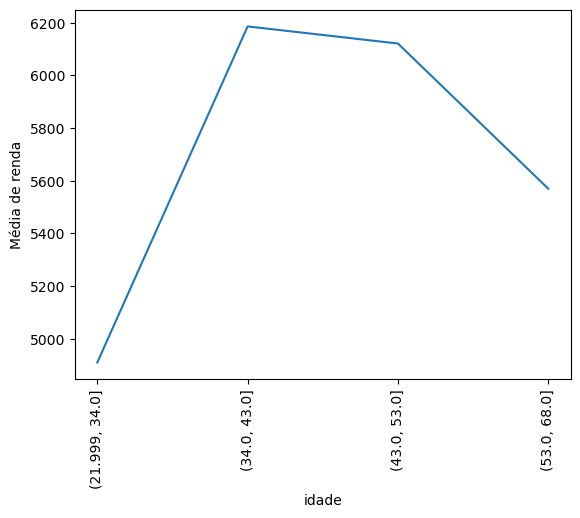

In [8]:
# análise da variável idade x renda
var = 'idade'
cat_srs, bins = pd.qcut(renda[var], 4, retbins=True)
g = renda.groupby(cat_srs)
biv = g['renda'].mean()

ax = biv.plot.line()
ax.set_ylabel("Média de renda")
ticks = plt.xticks(range(len(biv.index.values)), biv.index.values, rotation = 90)
plt.savefig('./output/figs/idade_renda.png')

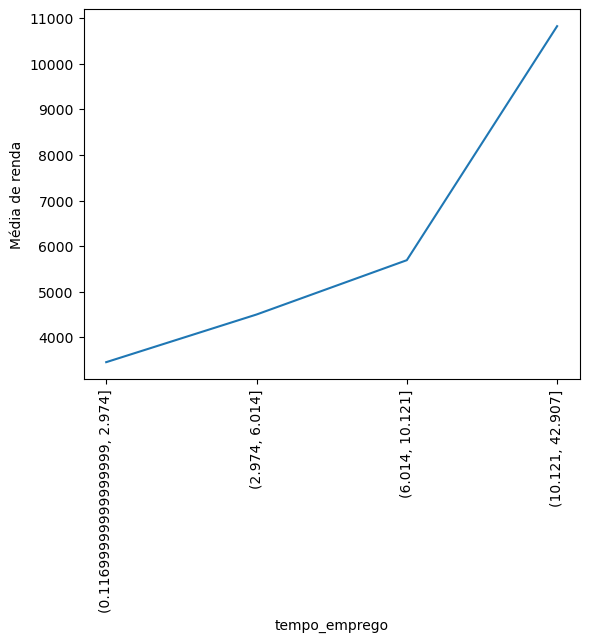

In [9]:
# análise da variável tempo_emprego x renda
var = 'tempo_emprego'
cat_srs, bins = pd.qcut(renda[var], 4, retbins=True)
g = renda.groupby(cat_srs)
biv = g['renda'].mean()

ax = biv.plot.line()
ax.set_ylabel("Média de renda")
ticks = plt.xticks(range(len(biv.index.values)), biv.index.values, rotation = 90)
plt.savefig('./output/figs/t_emprego_renda.png')

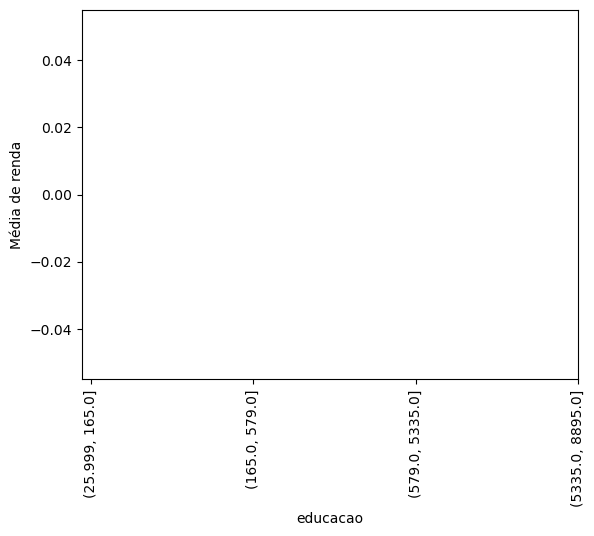

In [12]:
# análise da variável educacao x renda
var = 'educacao'
cat_srs, bins = pd.qcut(renda[var].value_counts(), 4, retbins=True)
g = renda.groupby(cat_srs)
biv = g['renda'].mean()

ax = biv.plot.line()
ax.set_ylabel("Média de renda")
ticks = plt.xticks(range(len(biv.index.values)), biv.index.values, rotation = 90)
plt.savefig('./output/figs/t_emprego_renda.png')

## Etapa 3 Crisp-DM: Preparação dos dados <a name="3"></a>
<div style="text-align: right" 
     
[Voltar ao índice](#topo)

Nessa etapa realizamos tipicamente as seguintes operações com os dados:

 - **seleção**: Já temos os dados selecionados adequadamente?
 - **limpeza**: Precisaremos identificar e tratar dados faltantes
 - **construção**: construção de novas variáveis
 - **integração**: Temos apenas uma fonte de dados, não é necessário integração
 - **formatação**: Os dados já se encontram em formatos úteis?

In [13]:
renda_1 = (renda.set_index('id_cliente')
    .assign(data_ref = lambda x: pd.to_datetime(x.data_ref)) # transformei data_ref para o tipo datetime
    .drop('Unnamed: 0', axis = 1) # exclui a coluna 'Unnamed: 0' pq ela não fazia muito sentido ali
    .dropna() # removi os NA, mas sobretudo da coluna 'tempo_emprego'
        )
print(renda_1.info())
renda_1.head()
# parece que o resultado foi positivo

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12427 entries, 15056 to 14651
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   data_ref               12427 non-null  datetime64[ns]
 1   sexo                   12427 non-null  object        
 2   posse_de_veiculo       12427 non-null  bool          
 3   posse_de_imovel        12427 non-null  bool          
 4   qtd_filhos             12427 non-null  int64         
 5   tipo_renda             12427 non-null  object        
 6   educacao               12427 non-null  object        
 7   estado_civil           12427 non-null  object        
 8   tipo_residencia        12427 non-null  object        
 9   idade                  12427 non-null  int64         
 10  tempo_emprego          12427 non-null  float64       
 11  qt_pessoas_residencia  12427 non-null  float64       
 12  renda                  12427 non-null  float64       
dt

,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
id_cliente,,,,,,,,,,,,,
15056,2015-01-01,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34
9968,2015-01-01,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15
4312,2015-01-01,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,2253.89
10639,2015-01-01,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,4.846575,3.0,6600.77
7064,2015-01-01,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1.0,6475.97


<span style="color:red">ESCREVER AQUI</span>


## Etapa 4 Crisp-DM: Modelagem <a name="4"></a>
<div style="text-align: right" 
     
[Voltar ao índice](#topo)                         

Nessa etapa que realizaremos a construção do modelo. Os passos típicos são:
- A técnica selecionada foi a de regressão com múltiplas variáveis.
- Pasty e statsmodel serão usados
- Através do stepwise foram selecionadas as melhores variáveis para o modelo

- Desenho do teste
- Avaliação do modelo




In [14]:
# criando a lista com todas as variáveis separadas por +. Copiar a saída e colar no modelo
var = renda_1.columns.to_list()
var.pop(-1), var.pop(0)
var = ' + '.join(var)
var

'sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia'

In [15]:
# criando a designe matrix e separando a variável resposta

y = renda_1.renda.copy()

X = (renda_1.drop(columns = ['renda', 'data_ref'], axis = 1)
     .assign(posse_de_veiculo = lambda a: a.posse_de_veiculo.replace({True : 1, False : 0}))
     .assign(posse_de_imovel = lambda a: a.posse_de_imovel.replace({True : 1, False : 0}))
     #.assign(X = lambda a: pd.get_dummies(a, drop_first = True)) # não consegui usar essa linha no encadeamento de métodos
     #.assign(sexo = lambda x: x.sexo.replace({'F':1, 'M':0})) # transformei em dummy a variável sexo
    )
X = pd.get_dummies(X, drop_first = True, dtype = int)
print(y)
print(X.info())
X.head(3)

id_cliente
15056    8060.34
9968     1852.15
4312     2253.89
10639    6600.77
7064     6475.97
          ...   
11477    1592.57
16006    7990.58
6194      604.82
4922     3352.27
14651    1160.99
Name: renda, Length: 12427, dtype: float64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12427 entries, 15056 to 14651
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   posse_de_veiculo               12427 non-null  int64  
 1   posse_de_imovel                12427 non-null  int64  
 2   qtd_filhos                     12427 non-null  int64  
 3   idade                          12427 non-null  int64  
 4   tempo_emprego                  12427 non-null  float64
 5   qt_pessoas_residencia          12427 non-null  float64
 6   sexo_M                         12427 non-null  int32  
 7   tipo_renda_Bolsista            12427 non-null  int32  
 8   tipo_renda_Empresário          12427 non-

,posse_de_veiculo,posse_de_imovel,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,sexo_M,tipo_renda_Bolsista,tipo_renda_Empresário,tipo_renda_Pensionista,...,educacao_Superior incompleto,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
id_cliente,,,,,,,,,,,,,,,,,,,,,
15056,0,1,0,26,6.602740,1.0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
9968,1,1,0,28,7.183562,2.0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4312,1,1,0,35,0.838356,2.0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [16]:
# separando entre treino e test X e y criados anteriormente
#25% para teste e 75% para treino
# usando o random state para garantir que os resultados seam sempre os mesmos em futuras análises.

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.25)

#### - Treinando a regressão

In [17]:
modelo = sm.OLS(y_train, X_train).fit() # este método não lê booleanos muito bem. geralmente acusa um erro, outraz vezes passa

modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  renda   R-squared (uncentered):                   0.477
Model:                            OLS   Adj. R-squared (uncentered):              0.476
Method:                 Least Squares   F-statistic:                              353.1
Date:                Tue, 15 Aug 2023   Prob (F-statistic):                        0.00
Time:                        11:05:20   Log-Likelihood:                         -97071.
No. Observations:                9320   AIC:                                  1.942e+05
Df Residuals:                    9296   BIC:                                  1.944e+05
Df Model:                          24                                                  
Covariance Type:            nonrobust                                                  
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
posse_de_veiculo               -144.1180    182.063     -0.792      0.429    -501.001     212.765
posse_de_imovel                 355.2519    181.234      1.960      0.050      -0.006     710.509
qtd_filhos                     1001.0453    577.389      1.734      0.083    -130.764    2132.855
idade                            37.2509     10.280      3.624      0.000      17.100      57.402
tempo_emprego                   571.3694     13.353     42.788      0.000     545.194     597.545
qt_pessoas_residencia          -901.3538    554.895     -1.624      0.104   -1989.071     186.363
sexo_M                         6184.2705    188.776     32.760      0.000    5814.228    6554.313
tipo_renda_Bolsista           -1370.9595   2704.199     -0.507      0.612   -6671.781    3929.862
tipo_renda_Empresário           873.0363    194.050      4.499      0.000     492.656    1253.416
tipo_renda_Pensionista        -2891.8382   3066.154     -0.943      0.346   -8902.172    3118.496
tipo_renda_Servidor público     123.3087    286.517      0.430      0.667    -438.328     684.946
educacao_Pós graduação          -58.1209   2207.869     -0.026      0.979   -4386.028    4269.786
educacao_Secundário              99.9922    881.337      0.113      0.910   -1627.622    1827.606
educacao_Superior completo      633.7693    883.759      0.717      0.473   -1098.591    2366.130
educacao_Superior incompleto   -342.5414    956.875     -0.358      0.720   -2218.227    1533.144
estado_civil_Separado         -1028.4878    657.222     -1.565      0.118   -2316.786     259.811
estado_civil_Solteiro         -1306.8219    592.508     -2.206      0.027   -2468.267    -145.376
estado_civil_União             -531.3838    322.107     -1.650      0.099   -1162.784     100.017
estado_civil_Viúvo            -1082.9050    773.778     -1.400      0.162   -2599.680     433.870
tipo_residencia_Casa           -901.5457    695.242     -1.297      0.195   -2264.372     461.280
tipo_residencia_Com os pais    -926.5553    774.929     -1.196      0.232   -2445.586     592.476
tipo_residencia_Comunitário   -1151.4937   1440.891     -0.799      0.424   -3975.957    1672.969
tipo_residencia_Estúdio       -1332.9074   1262.377     -1.056      0.291   -3807.443    1141.628
tipo_residencia_Governamental  -617.1931    850.495     -0.726      0.468   -2284.350    1049.964
==============================================================================
Omnibus:                    13577.551   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8114701.910
Skew:                           8.599   Prob(JB):                         0.00
Kurtosis:             

### Rodando o modelo


In [20]:
# rodando o método stepwise na base de treino
variaveis = stepwise_selection(X_train, y_train, )

print('resulting features:')
print(variaveis)

Add  tempo_emprego                  with p-value 0.0
#############
['tempo_emprego']
Add  sexo_M                         with p-value 1.26513e-242
#############
['tempo_emprego', 'sexo_M']
Add  tipo_renda_Empresário          with p-value 4.12304e-06
#############
['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário']
Add  idade                          with p-value 2.37794e-05
#############
['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário', 'idade']
Add  educacao_Superior completo     with p-value 0.00080423
#############
['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário', 'idade', 'educacao_Superior completo']
Add  posse_de_imovel                with p-value 0.043736
#############
['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário', 'idade', 'educacao_Superior completo', 'posse_de_imovel']
#############
['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário', 'idade', 'educacao_Superior completo', 'posse_de_imovel']
resulting features:
['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário',

In [22]:
# rodando a regressão com o stepwise na base de treino
reg_stepwise = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train[variaveis]))).fit()
reg_stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     505.3
Date:                Tue, 15 Aug 2023   Prob (F-statistic):               0.00
Time:                        11:18:55   Log-Likelihood:                -97075.
No. Observations:                9320   AIC:                         1.942e+05
Df Residuals:                    9313   BIC:                         1.942e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                      -2878.6879    417.758     -6.891      0.000   -3697.586   -2059.790
tempo_emprego                571.0854     13.213     43.221      0.000     545.185     596.986
sexo_M                      6202.1282    177.260     34.989      0.000    5854.661    6549.596
tipo_renda_Empresário        836.5997    188.680      4.434      0.000     466.746    1206.453
idade                         40.9597      9.561      4.284      0.000      22.217      59.702
educacao_Superior completo   571.4215    173.693      3.290      0.001     230.944     911.899
posse_de_imovel              357.1090    177.060      2.017      0.044      10.034     704.184
==============================================================================
Omnibus:                    13578.919   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8122349.469
Skew:                           8.601   Prob(JB):                         0.00
Kurtosis:                     146.597   Cond. No.                         218.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- Após o stepwise, naturalmente o R-quadrado caiu de 0.47 para 0.24. mas restaram somente as variáveis cujo P-value é inferior a 0.5.
- Realizarei algumas reglarizações lasso e ridge.

In [75]:
# usando o último modelo e sua seleção de variáveis
# testando regularização lasso com as variações do alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1 ,0.9]

md_stepwise_uft = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train[variaveis])))
reg_stepwise2 = md_stepwise_uft.fit_regularized(method = 'elastic_net' 
                         , refit = True
                         , L1_wt = 1 # quando 0 = ridge, quando 1 = lasso. Não consegui usar o 0, logo, quando 0.1 = ridge
                         , alpha = 0.005)
reg_stepwise2.summary()

# nenhum valor de alpha apresentou mudança nos parâmetros

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     433.1
Date:                Tue, 15 Aug 2023   Prob (F-statistic):               0.00
Time:                        11:47:20   Log-Likelihood:                -97075.
No. Observations:                9320   AIC:                         1.942e+05
Df Residuals:                    9313   BIC:                         1.942e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                      -2878.6879    417.758     -6.891      0.000   -3697.586   -2059.790
tempo_emprego                571.0854     13.213     43.221      0.000     545.185     596.986
sexo_M                      6202.1282    177.260     34.989      0.000    5854.661    6549.596
tipo_renda_Empresário        836.5997    188.680      4.434      0.000     466.746    1206.453
idade                         40.9597      9.561      4.284      0.000      22.217      59.702
educacao_Superior completo   571.4215    173.693      3.290      0.001     230.944     911.899
posse_de_imovel              357.1090    177.060      2.017      0.044      10.034     704.184
==============================================================================
Omnibus:                    13578.919   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8122349.469
Skew:                           8.601   Prob(JB):                         0.00
Kurtosis:                     146.597   Cond. No.                         218.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [77]:
# usando o último modelo e sua seleção de variáveis
# testando regularização ridge com as variações do alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.9]

md_stepwise_uft = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train[variaveis])))
reg_stepwise3 = md_stepwise_uft.fit_regularized(method = 'elastic_net' 
                         , refit = True
                         , L1_wt = 0.1 # quando 0 = ridge, quando 1 = lasso. Não consegui usar o 0, logo, quando 0.1 = ridge
                         , alpha = 0.05)
reg_stepwise3.summary()

# nenhum valor de alpha apresentou mudança nos parâmetros

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     433.1
Date:                Tue, 15 Aug 2023   Prob (F-statistic):               0.00
Time:                        11:49:00   Log-Likelihood:                -97075.
No. Observations:                9320   AIC:                         1.942e+05
Df Residuals:                    9313   BIC:                         1.942e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                      -2878.6879    417.758     -6.891      0.000   -3697.586   -2059.790
tempo_emprego                571.0854     13.213     43.221      0.000     545.185     596.986
sexo_M                      6202.1282    177.260     34.989      0.000    5854.661    6549.596
tipo_renda_Empresário        836.5997    188.680      4.434      0.000     466.746    1206.453
idade                         40.9597      9.561      4.284      0.000      22.217      59.702
educacao_Superior completo   571.4215    173.693      3.290      0.001     230.944     911.899
posse_de_imovel              357.1090    177.060      2.017      0.044      10.034     704.184
==============================================================================
Omnibus:                    13578.919   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8122349.469
Skew:                           8.601   Prob(JB):                         0.00
Kurtosis:                     146.597   Cond. No.                         218.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [78]:
# usando o último modelo e sua seleção de variáveis
# testando regularização variando o L1 com as variações do alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.9]

md_stepwise_uft = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train[variaveis])))
reg_stepwise4 = md_stepwise_uft.fit_regularized(method = 'elastic_net' 
                         , refit = True
                         , L1_wt = 0.7 # quando 0 = ridge, quando 1 = lasso. Não consegui usar o 0, logo, quando 0.1 = ridge
                         , alpha = 0.001)
reg_stepwise4.summary()

# nenhuma outra alteração de parâmetros alterando o L1_wt com as alterações de alpha também

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     433.1
Date:                Tue, 15 Aug 2023   Prob (F-statistic):               0.00
Time:                        11:49:16   Log-Likelihood:                -97075.
No. Observations:                9320   AIC:                         1.942e+05
Df Residuals:                    9313   BIC:                         1.942e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                      -2878.6879    417.758     -6.891      0.000   -3697.586   -2059.790
tempo_emprego                571.0854     13.213     43.221      0.000     545.185     596.986
sexo_M                      6202.1282    177.260     34.989      0.000    5854.661    6549.596
tipo_renda_Empresário        836.5997    188.680      4.434      0.000     466.746    1206.453
idade                         40.9597      9.561      4.284      0.000      22.217      59.702
educacao_Superior completo   571.4215    173.693      3.290      0.001     230.944     911.899
posse_de_imovel              357.1090    177.060      2.017      0.044      10.034     704.184
==============================================================================
Omnibus:                    13578.919   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8122349.469
Skew:                           8.601   Prob(JB):                         0.00
Kurtosis:                     146.597   Cond. No.                         218.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Realizarei algumas transformações na variável resposta para avaliar se há melhorar ou piora do modelo.

In [98]:
# transformarei power2, log e exp
y_train_t = np.log(y_train)
print(y_train)
y_train_t

id_cliente
1874      2255.09
6630      4263.03
11933      729.12
10060     2415.14
14985    13817.67
           ...   
16293      957.87
14708     2398.34
2638      1705.55
7702      6893.96
5230       368.90
Name: renda, Length: 9320, dtype: float64


id_cliente
1874     7.720945
6630     8.357735
11933    6.591838
10060    7.789513
14985    9.533703
           ...   
16293    6.864712
14708    7.782532
2638     7.441643
7702     8.838401
5230     5.910526
Name: renda, Length: 9320, dtype: float64

In [99]:
md_stepwise = sm.OLS(y_train_t, sm.add_constant(pd.DataFrame(X_train[variaveis])))
reg_stepwise4 = md_stepwise.fit_regularized(method = 'elastic_net' 
                         , refit = True
                         , L1_wt = 1 # quando 0 = ridge, quando 1 = lasso. Não consegui usar o 0, logo, quando 0.1 = ridge
                         , alpha = 0.001) # apliquei variações do alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.9]
reg_stepwise4.summary()


# aplicando log em 'renda' todos os parâmetros melhoram. 
# R-quadrado de 0.24 p 0.35; AIC diminui; os P-values chegam a 0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     720.9
Date:                Tue, 15 Aug 2023   Prob (F-statistic):               0.00
Time:                        12:03:18   Log-Likelihood:                -10208.
No. Observations:                9320   AIC:                         2.043e+04
Df Residuals:                    9313   BIC:                         2.049e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          7.1540      0.037    191.187      0.000       7.081       7.227
sexo_M                         0.7963      0.016     50.151      0.000       0.765       0.827
tipo_renda_Empresário          0.1509      0.017      8.926      0.000       0.118       0.184
idade                          0.0051      0.001      5.902      0.000       0.003       0.007
educacao_Superior completo     0.1177      0.016      7.564      0.000       0.087       0.148
posse_de_imovel                0.0934      0.016      5.888      0.000       0.062       0.124
tempo_emprego                  0.0611      0.001     51.644      0.000       0.059       0.063
==============================================================================
Omnibus:                        0.904   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.636   Jarque-Bera (JB):                0.867
Skew:                           0.018   Prob(JB):                        0.648
Kurtosis:                       3.030   Cond. No.                         218.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Realizarei algumas transformações nas variáveis explicativas selecionadas pelo stepwise para avaliar se há melhorar ou piora do modelo:
``'tempo_emprego', 'sexo_M', 'tipo_renda_Empresário', 'idade', 'educacao_Superior completo', 'posse_de_imovel'``

In [144]:
X_train['idade_t'] = np.power(X_train['idade'], 2)

# adicionando e removendo as variáveis da lista variaveis que identifica em X_train quais colunas buscar
#variaveis.append('idade') 
variaveis.remove('qt_pessoas_residencia_t')

print(variaveis)
X_train.head(3)

['sexo_M', 'tipo_renda_Empresário', 'idade', 'educacao_Superior completo', 'posse_de_imovel', 'tempo_emprego']


,posse_de_veiculo,posse_de_imovel,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,sexo_M,tipo_renda_Bolsista,tipo_renda_Empresário,tipo_renda_Pensionista,...,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental,tempo_emprego_power,tempo_emprego_t,sexo_M_t,tipo_renda_Empresário_t,idade_t,qt_pessoas_residencia_t
id_cliente,,,,,,,,,,,,,,,,,,,,,
1874,1,1,0,50,5.509589,2.0,0,0,0,0,...,0,0,0,0,30.355571,1.706490,0,0,2500,4.0
6630,0,1,1,23,1.158904,3.0,1,0,0,0,...,0,0,0,0,1.343059,0.147475,1,0,529,9.0
11933,0,0,0,41,0.578082,2.0,1,0,0,0,...,0,0,0,0,0.334179,-0.548039,1,0,1681,4.0


In [145]:
md_stepwise = sm.OLS(y_train_t, sm.add_constant(pd.DataFrame(X_train[variaveis])))
reg_stepwise4 = md_stepwise.fit_regularized(method = 'elastic_net' 
                         , refit = True
                         , L1_wt = 1 # quando 0 = ridge, quando 1 = lasso. Não consegui usar o 0, logo, quando 0.1 = ridge
                         , alpha = 0.001) # apliquei variações do alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.9]
reg_stepwise4.summary()

# em 'tempo_emprego', aplicando qualquer das transformações os valores foram piores
# em 'idade', os valores dos parÂmetros pioraram
# nenhuma transformação de variáveis continuas ou discretas resultou numa melhora do modelo

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     720.9
Date:                Tue, 15 Aug 2023   Prob (F-statistic):               0.00
Time:                        15:02:56   Log-Likelihood:                -10208.
No. Observations:                9320   AIC:                         2.043e+04
Df Residuals:                    9313   BIC:                         2.049e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          7.1540      0.037    191.187      0.000       7.081       7.227
sexo_M                         0.7963      0.016     50.151      0.000       0.765       0.827
tipo_renda_Empresário          0.1509      0.017      8.926      0.000       0.118       0.184
idade                          0.0051      0.001      5.902      0.000       0.003       0.007
educacao_Superior completo     0.1177      0.016      7.564      0.000       0.087       0.148
posse_de_imovel                0.0934      0.016      5.888      0.000       0.062       0.124
tempo_emprego                  0.0611      0.001     51.644      0.000       0.059       0.063
==============================================================================
Omnibus:                        0.904   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.636   Jarque-Bera (JB):                0.867
Skew:                           0.018   Prob(JB):                        0.648
Kurtosis:                       3.030   Cond. No.                         218.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Rodando o modelo na base de test com os parâmetros que foram treinados antes.

In [147]:
# transformar y com np.log
y_test_t = np.log(y_test)
print(y_test)
y_test_t

id_cliente
2638      1705.55
13392     1748.99
12390     1733.67
5753      2378.25
10349     1957.87
           ...   
5710     11816.81
14535     8922.74
15001    13070.17
11542     3750.94
14979     2581.24
Name: renda, Length: 3107, dtype: float64


id_cliente
2638     7.441643
13392    7.466794
12390    7.457996
5753     7.774120
10349    7.579612
           ...   
5710     9.377278
14535    9.096358
15001    9.478088
11542    8.229762
14979    7.856025
Name: renda, Length: 3107, dtype: float64

In [177]:
            # coef	std err	t	P>|t|	[0.025	0.975]
# posse_de_imovel	0	0	nan	nan	0	0
# posse_de_imovel resultou em nan para P-value e t, portanto, transformarei-a até que o problema seja sanado

X_test['posse_de_imovel_t'] = np.exp(X_test['posse_de_imovel'])

# adicionando e removendo as variáveis da lista variaveis que identifica em X_train quais colunas buscar
#variaveis.append('posse_de_imovel_t') 
#variaveis.remove('posse_de_imovel')

print(variaveis)
X_test.head(3)

# aplicando np.exp em posse_de_imovel, o problema foi resolvido de nan

['sexo_M', 'tipo_renda_Empresário', 'idade', 'educacao_Superior completo', 'tempo_emprego', 'posse_de_imovel_t']


,posse_de_veiculo,posse_de_imovel,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,sexo_M,tipo_renda_Bolsista,tipo_renda_Empresário,tipo_renda_Pensionista,...,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental,posse_de_imovel_t
id_cliente,,,,,,,,,,,,,,,,,,,,,
2638,1,1,0,29,1.306849,2.0,1,0,0,0,...,0,0,1,0,1,0,0,0,0,2.718282
13392,0,0,0,26,0.600000,1.0,1,0,1,0,...,0,1,0,0,1,0,0,0,0,1.000000
12390,1,1,1,46,1.115068,3.0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,2.718282


In [178]:
md_stepwise = sm.OLS(y_test_t, sm.add_constant(pd.DataFrame(X_test[variaveis])))
reg_stepwise5 = md_stepwise.fit_regularized(method = 'elastic_net' 
                         , refit = True
                         , L1_wt = 1 # quando 0 = ridge, quando 1 = lasso. Não consegui usar o 0, logo, quando 0.1 = ridge
                         , alpha = 0.001) # apliquei variações do alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.9]
reg_stepwise5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     254.9
Date:                Tue, 15 Aug 2023   Prob (F-statistic):          2.13e-300
Time:                        15:20:13   Log-Likelihood:                -3383.2
No. Observations:                3107   AIC:                             6782.
Df Residuals:                    3100   BIC:                             6831.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          7.1209      0.070    102.246      0.000       6.984       7.257
sexo_M                         0.8188      0.027     30.060      0.000       0.765       0.872
tipo_renda_Empresário          0.1187      0.029      4.158      0.000       0.063       0.175
idade                          0.0047      0.001      3.158      0.002       0.002       0.008
educacao_Superior completo     0.1131      0.027      4.193      0.000       0.060       0.166
tempo_emprego                  0.0644      0.002     30.749      0.000       0.060       0.069
posse_de_imovel_t              0.0356      0.016      2.252      0.024       0.005       0.067
==============================================================================
Omnibus:                        0.361   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.835   Jarque-Bera (JB):                0.406
Skew:                           0.020   Prob(JB):                        0.816
Kurtosis:                       2.961   Cond. No.                         232.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [187]:
reg = sm.OLS(y,X).fit()
renda_2 = (renda_1.assign(res_log = lambda x: reg.resid)
           .assign(renda_log = lambda x: np.log(x['renda']))
          )
 
renda_2

,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,res_log,renda_log
id_cliente,,,,,,,,,,,,,,,
15056,2015-01-01,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34,5305.455312,8.994711
9968,2015-01-01,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15,-7630.939477,7.524102
4312,2015-01-01,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,2253.89,1234.147262,7.720413
10639,2015-01-01,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,4.846575,3.0,6600.77,4142.976250,8.794942
7064,2015-01-01,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1.0,6475.97,-555.178016,8.775854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11477,2016-03-01,M,True,False,0,Empresário,Superior incompleto,Casado,Casa,32,9.849315,2.0,1592.57,-8963.297935,7.373104
16006,2016-03-01,F,False,True,0,Empresário,Secundário,Solteiro,Casa,48,13.887671,1.0,7990.58,316.105422,8.986019
6194,2016-03-01,F,True,True,0,Assalariado,Superior completo,Casado,Casa,45,7.832877,2.0,604.82,-3883.129134,6.404931


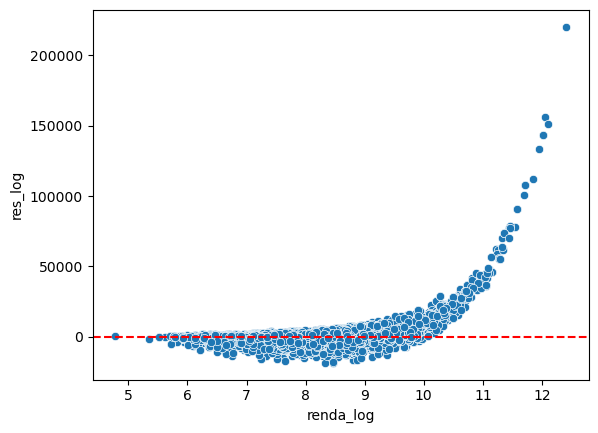

In [188]:
sns.scatterplot(x = 'renda_log', y = 'res_log', data = renda_2)
plt.axhline(y=0, color='r', linestyle='--')

## Etapa 5 Crisp-DM: Avaliação dos resultados <a name="5"></a>
<div style="text-align: right" 
     
[Voltar ao índice](#topo)                    


- Após a análise dos dados, é possível afirmar que as variáveis selecionadas: ``'sexo_M``, ``tipo_renda_Empresário``, ``idade``, ``educacao_Superior completo``, ``tempo_emprego`` e ``posse_de_imovel_t'``, ajudam a explicar melhor a ``renda`` de um cliente da instituição financeira.

- Talvez, por questões éticas, seria orientado excluir a variável 'sexo_M' das explicativas. Variáveis que podem gerar algum tipo de segregação devem ser evitadas em análises desse tipo, de forma a evitar preconceitos e viéses maliciosos à sociedade.

- O modelo de regressão com as atuais variáveis, tem R-quadrado = 0.36, um ajustado = 0.34 e AIC = 6782. Todos os P-values estão abaixo de 0.05 o que indica que todas as variáveis são significativas para explicar renda.

- Alternativamente, um modelo de árvore de regressão poderia ser aplicado para tentar melhorar os parâmetros.

- Ao final, é possível perceber que o modelo tem muito resíduo e requer mais melhorias

## Etapa 6 Crisp-DM: Implantação <a name="6"></a>
<div style="text-align: right" 
     
[Voltar ao índice](#topo)                    

- A intenção agora é publicar os resultados numa página html via pacote streamlit.
- Um documento .py será entregue como produto para geração da página interativa.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import streamlit as st

sns.set(context='talk', style='ticks')

st.set_page_config(
     page_title="Análise de previsão de renda",
     page_icon="https://www.institutots.com.br/wp-content/uploads/2019/12/money-lover-app.png",
     layout="wide",
)

# SIDEBAR configurations

st.sidebar.write("# Seja bem-vindo!")

st.sidebar.write('Para obter informações detalhadas, por favor, realize o login. :red[Isto é só um teste!]')
with st.sidebar:
    with st.form(key='my_form'):
        username = st.text_input('Usuário')
        password = st.text_input('senha')
        st.form_submit_button('Login')
    st.markdown("O objetivo desta análise é prever a variação de renda dos clientes de uma instituição financeira. Os dados utilizados na análise e previsão foram coletados e distribuidos em variáveis com características diversas que auxiliam na previsão ou explicação da renda de um cliente.")

# tabs configuration

tab1, tab2, tab3, tab4, tab5 = st.tabs(["Home" 
                                        ,"Gráficos customizáveis" 
                                        ,"Univariadas" 
                                        ,"Bivariadas"
                                        ,"Dados brutos"]
                                        )

with tab1:
    
    renda = pd.read_csv('./input/previsao_de_renda.csv')
    st.title('Análise exploratória da :blue[Previsão de Renda]')
    st.markdown('#### Aqui você encontra informações referentes aos estudos de previsão de renda')
    st.image("https://vibratto.com.br/wpress/wp-content/uploads/2020/01/faturamento-clientes-empresa-neg%C3%B3cio-01.png")
    st.markdown("##### O objetivo desta análise é prever a variação de renda dos clientes de uma instituição financeira. Os dados utilizados na análise e previsão foram coletados e distribuidos em variáveis com características diversas que auxiliam na previsão ou explicação da renda de um cliente.")

with tab2:
    
    renda = pd.read_csv('./input/previsao_de_renda.csv')

    #Gráfico customizável univariadas

    st.write('# Gráfico customizável para análises univariadas')
    option1 = st.selectbox(
        'Selecione a variável que deseja exibir',
        ('sexo', 'posse_de_veiculo', 'posse_de_imovel', 
         'qtd_filhos', 'tipo_renda', 'educacao', 
         'estado_civil', 'tipo_residencia', 'idade', 
         'tempo_emprego', 'qt_pessoas_residencia')
        )
    
    fig = plt.figure(figsize=(10, 5))
    sns.lineplot(x='data_ref',y='renda', hue= option1 ,data=renda)
    plt.xlabel(option1)
    plt.xticks(rotation=45)
    st.pyplot(plt)

    #Gráfico customizável bivariadas
    
    st.divider()

    options = st.multiselect(
        'Selecione até duas variáveis que deseja cruzar',
        ['renda','sexo', 'posse_de_veiculo', 'posse_de_imovel', 
        'qtd_filhos', 'tipo_renda', 'educacao', 
        'estado_civil', 'tipo_residencia', 'idade', 
        'tempo_emprego', 'qt_pessoas_residencia'],
        ['educacao', 'renda']
        )
    
    st.write('# Gráfico customizável para análises bivariadas')
    fig = plt.figure(figsize=(10, 5))
    sns.barplot(x=options[0],y=options[1],data=renda)
    plt.xticks(rotation=30)
    st.pyplot(plt)

with tab3:

    #plots
    
    st.write('# Gráficos ao longo do tempo')
    st.divider()
    fig, ax = plt.subplots(6,1,figsize=(10,40))
    sns.lineplot(x='data_ref',y='renda', hue='posse_de_imovel',data=renda, ax=ax[0])
    ax[0].tick_params(axis='x', rotation=45)
    sns.lineplot(x='data_ref',y='renda', hue='posse_de_veiculo',data=renda, ax=ax[1])
    ax[1].tick_params(axis='x', rotation=45)
    sns.lineplot(x='data_ref',y='renda', hue='qtd_filhos',data=renda, ax=ax[2])
    ax[2].tick_params(axis='x', rotation=45)
    sns.lineplot(x='data_ref',y='renda', hue='tipo_renda',data=renda, ax=ax[3])
    ax[3].tick_params(axis='x', rotation=45)
    sns.lineplot(x='data_ref',y='renda', hue='educacao',data=renda, ax=ax[4])
    ax[4].tick_params(axis='x', rotation=45)
    sns.lineplot(x='data_ref',y='renda', hue='estado_civil',data=renda, ax=ax[5])
    ax[5].tick_params(axis='x', rotation=45)
    sns.despine()
    st.pyplot(plt)
     
with tab4:   

    st.write('# Gráficos das análises bivariadas')
    st.divider()
    fig, ax = plt.subplots(7,1,figsize=(10,40))
    sns.barplot(x='posse_de_imovel',y='renda',data=renda, ax=ax[0])
    sns.barplot(x='posse_de_veiculo',y='renda',data=renda, ax=ax[1])
    sns.barplot(x='qtd_filhos',y='renda',data=renda, ax=ax[2])
    sns.barplot(x='tipo_renda',y='renda',data=renda, ax=ax[3])
    sns.barplot(x='educacao',y='renda',data=renda, ax=ax[4])
    ax[4].tick_params(axis='x', rotation=20)
    sns.barplot(x='estado_civil',y='renda',data=renda, ax=ax[5])
    sns.barplot(x='tipo_residencia',y='renda',data=renda, ax=ax[6])
    ax[6].tick_params(axis='x', rotation=30)
    sns.despine()
    st.pyplot(plt)

with tab5:
    st.markdown("<h1 style='text-align: center; '>Dicionário de dados</h1>", unsafe_allow_html=True)

    st.markdown(
        """
        | Variável                | Descrição                                           | Tipo         |
        | ----------------------- |:---------------------------------------------------:| ------------:|
        | data_ref                |  Data de referência da coleta do dado               | texto|
        | id_cliente              |  Número de identificação do cliente                 | inteiro|
        | sexo                    |  M = 'Masculino'; F = 'Feminino'                    | inteiro|
        | posse_de_veiculo        |  True = 'possui'; False = 'não possui'              | booleana|
        | posse_de_imovel         |  True = 'possui'; False = 'não possui'              | booleana|
        | qtd_filhos              |  Quantidade de filhos do cliente                    | inteiro|
        | tipo_renda              |  Tipo de renda (ex: assaliariado, autônomo etc)     | texto|
        | educacao                |  Nível educacional (ex: secundário, superior etc)   | texto|
        | estado_civil            |  Estado civil (ex: solteiro, casado etc)            | texto|
        | tipo_residencia         |  Tipo de residência (ex: casa/apartamento, com os pais etc)| texto|
        | idade                   |  Idade em anos                                      | inteiro|
        | tempo_emprego           |  Tempo de emprego em anos                           | float|
        | qt_pessoas_residencia   |  Quantidade de pessoas na residência                | float|
        | renda                   |  Valor da renda mensal                              | float|
    """
    )
    st.divider()
    st.markdown("<h1 style='text-align: center; '>Base de dados</h1>", unsafe_allow_html=True)
    st.write(renda)